In [1]:
import pyodbc
from meyerDB import cable_connection
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
import sklearn.preprocessing as pp

# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

Database connection ok


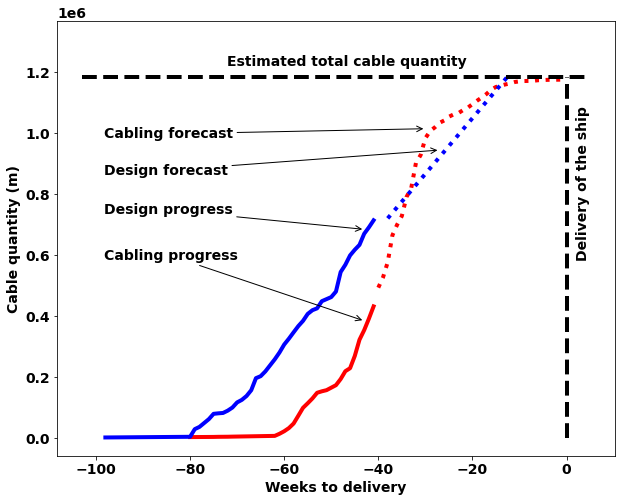

In [66]:

plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 'bold'

week = -40

# get total cable quantity estimate
cursor.execute("SELECT sum(amount) FROM routed WHERE project_id=1394 AND running LIKE 'Y%'")
goal = cursor.fetchone()[0]

# init plot
plt.figure(figsize=(10, 8))

# get new ship cabling progress
cursor.execute("SELECT rw, sum(amount) FROM ship_readiness "
" WHERE project_id=1396 AND running LIKE 'Y%' AND rw IS NOT NULL AND rw < {} GROUP BY rw, project_id ORDER BY rw"
    .format(week)
    )
data = np.array(cursor.fetchall()).astype('int32')
x = data[:, 0]
amount = data[:, 1]
cum_sum = amount.cumsum()
plt.plot(x, cum_sum, 'r-', linewidth=4)

# get sister ship cabling progress
cursor.execute("SELECT rw, sum(amount) FROM ship_readiness "
" WHERE project_id=1394 AND running LIKE 'Y%' AND rw IS NOT NULL GROUP BY rw, project_id ORDER BY rw"
    )
data = np.array(cursor.fetchall()).astype('int32')
x = data[:, 0]
amount = data[:, 1]
cum_sum = amount.cumsum()
idxs = np.where(x >= week)
cum_sum = cum_sum[idxs]
x = x[idxs]
plt.plot(x, cum_sum, 'r:', linewidth=4)

# get new ship design progress
cursor.execute("SELECT pw, sum(amount) FROM ship_readiness "
" WHERE project_id=1396 AND running LIKE 'Y%' AND rw IS NOT NULL AND pw < {} GROUP BY pw, project_id ORDER BY pw"
    .format(week)
    )
data = np.array(cursor.fetchall()).astype('int32')
x = data[:, 0]
amount = data[:, 1]
cum_sum = amount.cumsum()
plt.plot(x, cum_sum, color='b', linewidth=4)

idxs = np.where(x >= -80)
pred_coef = np.polyfit(x[idxs], cum_sum[idxs], 1)
x = [week+2, (goal-pred_coef[1])/pred_coef[0]]
y = np.poly1d(pred_coef)(x)
plt.plot(x, y, ':', color='b', linewidth=4)


# plot goal value
plt.plot(plt.xlim(), np.ones_like(plt.xlim())*goal, 'k--', linewidth=4)

# plot delivery
plt.plot([0, 0], [0, goal], 'k--', linewidth=4)

'''plt.legend(
    ['Current cabling progress', 'Cabling progress forecast', 'Current design progress', 'Design progress forecast'],
    bbox_to_anchor=(0, 0.8, 0, 0), loc='upper left'
    )'''
plt.xlabel('Weeks to delivery', fontsize=14, fontweight='bold')
plt.ylabel('Cable quantity (m)', fontsize=14, fontweight='bold')
#plt.yticks([])
#plt.xticks(color='w')
plt.text(plt.xlim()[0]/1.5, goal*1.03, 'Estimated total cable quantity')
plt.text(2, goal/2, 'Delivery of the ship', rotation=90)
plt.ylim(plt.ylim()[0], plt.ylim()[1]*1.1)

#callout labels
plt.annotate("Cabling forecast", xy=(-30, goal - 170000), xytext=(plt.xlim()[0]+10, goal - 200000), arrowprops=dict(arrowstyle="->"))
plt.annotate("Design forecast", xy=(-27, goal - 240000), xytext=(plt.xlim()[0]+10, goal - 320000), arrowprops=dict(arrowstyle="->"))
plt.annotate("Design progress", xy=(-43, goal - 500000), xytext=(plt.xlim()[0]+10, goal - 450000), arrowprops=dict(arrowstyle="->"))
plt.annotate("Cabling progress", xy=(-43, goal - 800000), xytext=(plt.xlim()[0]+10, goal - 600000), arrowprops=dict(arrowstyle="->"))



plt.savefig('introduction.png')
